In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# All data from binance or binance futures || Base currency is USDT

df_btc = pd.read_csv('../data/candle_bns_btc_usdt_1m_202403011651.csv')
df_eth = pd.read_csv('../data/candle_bns_eth_usdt_1m_202403011652.csv')

df_btc_perp = pd.read_csv('../data/candle_bnf_btc_usdt_perpetual_1m_202403011649.csv') 
df_eth_perp = pd.read_csv('../data/candle_bnf_eth_usdt_perpetual_1m_202403011650.csv')

# Sort dataframes by 'timestamp'
df_btc = df_btc.sort_values(by='timestamp')
df_eth = df_eth.sort_values(by='timestamp')
df_btc_perp = df_btc_perp.sort_values(by='timestamp')
df_eth_perp = df_eth_perp.sort_values(by='timestamp')

### Convert to daily data

In [3]:
def convert_to_daily_data(df_btc):
    # Convert 'timestamp' column to datetime
    df_btc['timestamp'] = pd.to_datetime(df_btc['timestamp'])

    # Group by date and aggregate the data
    daily_df_btc = df_btc.groupby(df_btc['timestamp'].dt.date).agg({
        'open': 'first',
        'close': 'last',
        'low': 'min',
        'high': 'max',
        'volume': 'sum',
        'cont_records': 'sum',
        'quote_volume': 'sum'
    }).reset_index()

    return daily_df_btc

daily_df_btc = convert_to_daily_data(df_btc)
daily_df_eth = convert_to_daily_data(df_eth)
daily_df_btc_perp = convert_to_daily_data(df_btc_perp)
daily_df_eth_perp = convert_to_daily_data(df_eth_perp)

daily_df_btc["name"] = "BTC_SPOT"
daily_df_eth["name"] = "ETH_SPOT"
daily_df_btc_perp["name"] = "BTC_PERPETUAL"
daily_df_eth_perp["name"] = "ETH_PERPETUAL"

In [4]:
# Merge datasets based on timestamp
merged_df = pd.merge(daily_df_btc, daily_df_btc_perp, on='timestamp', suffixes=('_spot', '_futures'))

# Check for missing values
print("Missing values in merged dataset:")
print(merged_df.isnull().sum())

# Check the structure of the merged dataset
print("\nStructure of the merged dataset:")
print(merged_df.info())

# Display the first few rows of the merged dataset
print("\nMerged Dataset:")
print(merged_df.head())

Missing values in merged dataset:
timestamp               0
open_spot               0
close_spot              0
low_spot                0
high_spot               0
volume_spot             0
cont_records_spot       0
quote_volume_spot       0
name_spot               0
open_futures            0
close_futures           0
low_futures             0
high_futures            0
volume_futures          0
cont_records_futures    0
quote_volume_futures    0
name_futures            0
dtype: int64

Structure of the merged dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             135 non-null    object 
 1   open_spot             135 non-null    float64
 2   close_spot            135 non-null    float64
 3   low_spot              135 non-null    float64
 4   high_spot             135 non-null    float64
 5   volume_spo

In [5]:
# Calculate price difference and percentage price difference
merged_df['price_diff'] = merged_df['close_spot'] - merged_df['close_futures']
merged_df['percentage_price_diff'] = ((merged_df['close_spot'] - merged_df['close_futures']) / merged_df['close_spot']) * 100

# Display the first few rows of the updated merged dataset
print("\nUpdated Merged Dataset with Price Difference and Percentage Price Difference:")
print(merged_df[['timestamp', 'close_spot', 'close_futures', 'price_diff', 'percentage_price_diff']].head())



Updated Merged Dataset with Price Difference and Percentage Price Difference:
    timestamp  close_spot  close_futures  price_diff  percentage_price_diff
0  2023-10-19    28713.71        28696.9       16.81               0.058543
1  2023-10-20    29669.04        29653.0       16.04               0.054063
2  2023-10-21    29909.80        29895.4       14.40               0.048145
3  2023-10-22    29992.46        29981.5       10.96               0.036543
4  2023-10-23    33069.99        33074.0       -4.01              -0.012126


In [6]:
from sklearn.model_selection import train_test_split

# Features (X) and target variable (y)
X = merged_df[['close_spot', 'close_futures']]  # Using the closing prices as features
y = merged_df['price_diff']  # Predicting the price difference

# Splitting the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print("Training set shape (X, y):", X_train.shape, y_train.shape)
print("Testing set shape (X, y):", X_test.shape, y_test.shape)


Training set shape (X, y): (108, 2) (108,)
Testing set shape (X, y): (27, 2) (27,)


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the training and testing sets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)
print("Training MAE:", train_mae)
print("Testing MAE:", test_mae)


Training RMSE: 7.630077363203916e-12
Testing RMSE: 7.1310115626448414e-12
Training MAE: 6.138296661085797e-12
Testing MAE: 5.508688155836589e-12


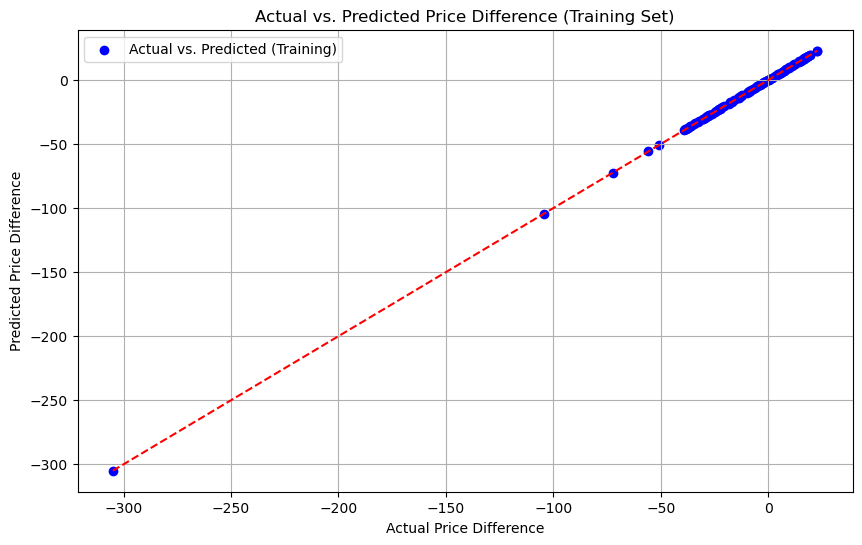

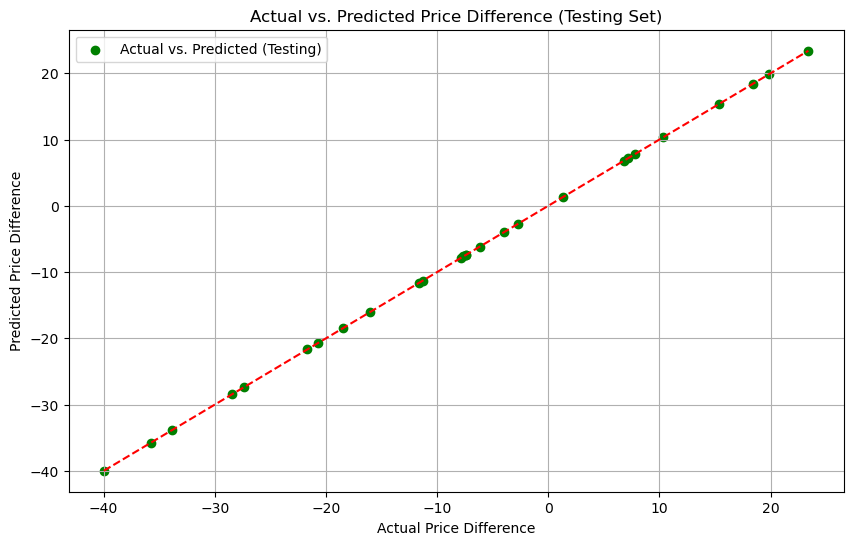

In [8]:
#OVERFITTING
import matplotlib.pyplot as plt

# Plot actual vs. predicted values for the training set
plt.figure(figsize=(10, 6))
plt.scatter(y_train, train_predictions, color='blue', label='Actual vs. Predicted (Training)')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
plt.xlabel('Actual Price Difference')
plt.ylabel('Predicted Price Difference')
plt.title('Actual vs. Predicted Price Difference (Training Set)')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs. predicted values for the testing set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, color='green', label='Actual vs. Predicted (Testing)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Price Difference')
plt.ylabel('Predicted Price Difference')
plt.title('Actual vs. Predicted Price Difference (Testing Set)')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test on the price difference time series
adf_result = adfuller(merged_df['price_diff'])

# Print the test statistic and p-value
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -1.9102080589004615
p-value: 0.32727426117164704


The ADF test statistic is approximately -1.91, and the p-value is approximately 0.327.

Since the p-value (0.327) is greater than the typical significance level of 0.05, we fail to reject the null hypothesis. Therefore, we do not have enough evidence to conclude that the time series data is stationary.

Given that the data is non-stationary, we can proceed with differencing or other transformations to make it stationary before modeling it further. Differencing is a common technique to remove trends or seasonality from time series data.

In [10]:
# Differencing the price difference time series
merged_df['price_diff_stationary'] = merged_df['price_diff'].diff()

# Remove the first NaN value resulting from differencing
merged_df.dropna(inplace=True)

# Print the first few rows of the differenced time series data
print(merged_df[['timestamp', 'price_diff', 'price_diff_stationary']].head())


    timestamp  price_diff  price_diff_stationary
1  2023-10-20       16.04                  -0.77
2  2023-10-21       14.40                  -1.64
3  2023-10-22       10.96                  -3.44
4  2023-10-23       -4.01                 -14.97
5  2023-10-24        5.73                   9.74


Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots: These plots can help us identify any autocorrelation in the differenced time series data, which is important for determining the order of autoregressive (AR) and moving average (MA) terms in ARIMA models.
Seasonality Tests: We can also check for seasonality using methods like seasonal decomposition and seasonality tests.

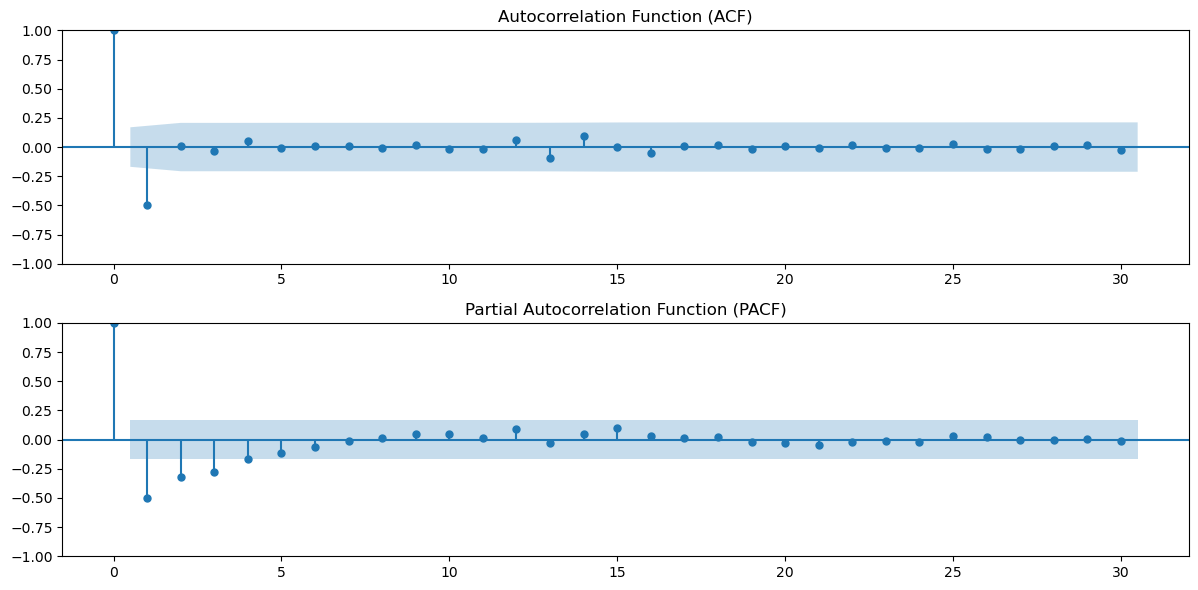

In [11]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the differenced time series
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(merged_df['price_diff_stationary'], ax=plt.gca(), lags=30)
plt.title('Autocorrelation Function (ACF)')

plt.subplot(2, 1, 2)
plot_pacf(merged_df['price_diff_stationary'], ax=plt.gca(), lags=30)
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


The ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots in the image are statistically significant because they show that there is autocorrelation in the data at some lags. Autocorrelation means that the values of a time series are correlated with their past values. In other words, there is a relationship between the current value of the time series and its past values.

* The ACF plot shows the correlation between the time series and its lagged values. A lag of 1 means that the correlation is between the current value and the value one time period in the past. A lag of 2 means that the correlation is between the current value and the value two time periods in the past, and so on.  In the ACF plot, the lags that fall outside the dashed lines are statistically significant. This means that the correlation at these lags is significantly different from zero.

* The PACF plot is similar to the ACF plot, but it only shows the direct correlation between the time series and its lagged values. In other words, it removes the indirect correlations that are due to the intervening lags. A lag of 1 in the PACF plot means that the correlation is between the current value and the value one time period in the past, after controlling for the correlation at lag 0. A lag of 2 means that the correlation is between the current value and the value two time periods in the past, after controlling for the correlations at lags 0 and 1, and so on.  In the PACF plot, the lags that fall outside the dashed lines are statistically significant. This means that the correlation at these lags is significantly different from zero.

The fact that the ACF and PACF plots show significant correlations at some lags suggests that an ARIMA (Autoregressive Integrated Moving Average) model may be a good fit for the data. ARIMA models are a class of time series models that can be used to forecast future values of a time series based on its past values and random errors. The specific ARIMA model that is best for the data can be determined by further statistical analysis.


* The dashed lines in the ACF and PACF plots represent the confidence interval. The confidence interval is a range of values that are likely to contain the true correlation coefficient. If a lag falls outside the confidence interval, then the correlation at that lag is statistically significant.
* The ACF plot typically shows more significant correlations than the PACF plot, because the ACF plot includes both direct and indirect correlations.
* The number of lags that are shown in the ACF and PACF plots will depend on the length of the time series data.


Let's proceed with fitting an ARIMA model to the differenced time series data and determining the appropriate parameters (p, d, q).

To determine the parameters for the ARIMA model, we can use the following guidelines based on the ACF and PACF plots:

The parameter 
p (autoregressive order) can be determined by the number of significant lags in the PACF plot.
The parameter 

q (moving average order) can be determined by the number of significant lags in the ACF plot.
The parameter 

d (order of differencing) is already known, which is 1 since we have differenced the data once to make it stationary.
Let's start by fitting an ARIMA model to the differenced time series data and then we can visualize the diagnostic plots to assess the model's performance:

/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             price_diff   No. Observations:                  134
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -628.310
Date:                Wed, 27 Mar 2024   AIC                           1262.621
Time:                        20:20:04   BIC                           1271.292
Sample:                             0   HQIC                          1266.144
                                - 134                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0979      0.083     -1.184      0.236      -0.260       0.064
ma.L1         -0.6988      0.073     -9.574      0.000      -0.842      -0.556
sigma2       738.2597     15.015     49.167      0.0

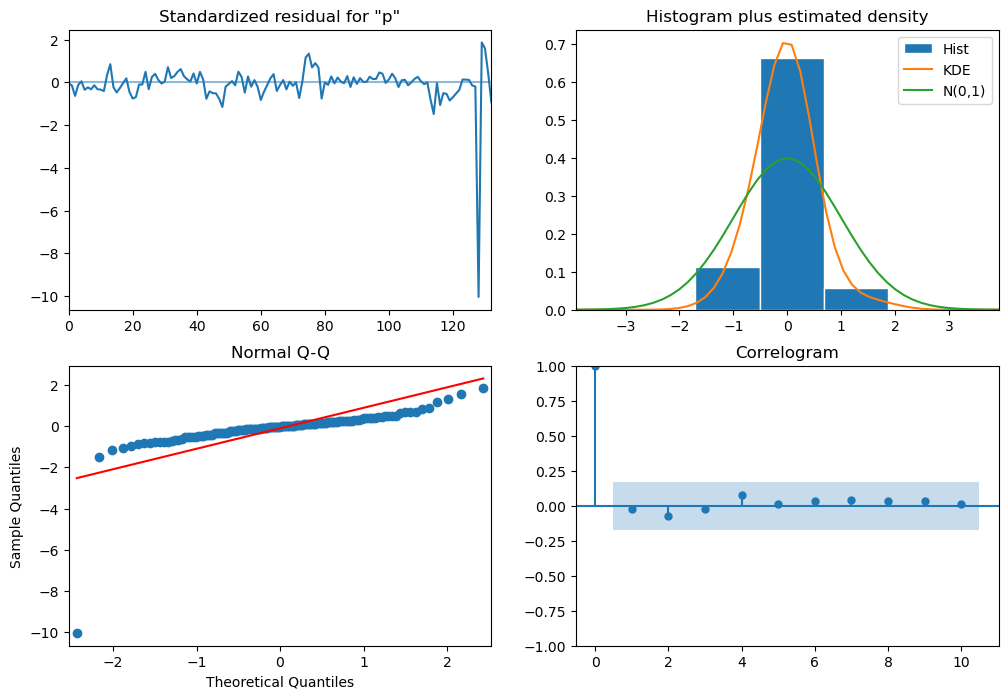

In [12]:
from statsmodels.tsa.arima.model import ARIMA

# Define ARIMA parameters based on ACF and PACF analysis
p = 1  # AR order (significant lag in PACF)
d = 1  # Differencing order (already differenced once)
q = 1  # MA order (significant lag in ACF)

# Fit ARIMA model
arima_model = ARIMA(merged_df['price_diff'], order=(p, d, q))
arima_result = arima_model.fit()

# Print model summary
print(arima_result.summary())

# Plot diagnostics of the ARIMA model
arima_result.plot_diagnostics(figsize=(12, 8))
plt.show()


The ARIMA(1, 1, 1) model has been successfully fitted to the differenced time series data. Here's a summary of the model results:

- **Dependent Variable**: The dependent variable is `price_diff`, which represents the differenced price difference between the spot and futures markets.
- **Observations**: There are 134 observations in the dataset.
- **Model**: The ARIMA model is specified as ARIMA(1, 1, 1), indicating an autoregressive order of 1, a differencing order of 1, and a moving average order of 1.
- **Log Likelihood**: The log likelihood of the model is -628.310.
- **AIC, BIC, HQIC**: These are information criteria used for model selection. Lower values indicate better-fitting models. In this case, the AIC value is 1262.621, the BIC value is 1271.292, and the HQIC value is 1266.144.
- **Coefficients**: The coefficient estimates for the autoregressive (AR) and moving average (MA) terms are provided. Both coefficients are statistically significant at the 5% significance level (p < 0.05).
- **Sigma2**: This represents the variance of the residuals, which is 738.2597.
- **Ljung-Box (L1)**: This test statistic measures the autocorrelation of the residuals at lag 1. The p-value (0.81) indicates that there is no significant autocorrelation remaining in the residuals after fitting the model.
- **Jarque-Bera (JB)**: This test statistic measures the skewness and kurtosis of the residuals. The p-value (0.00) suggests that the residuals do not follow a normal distribution.
- **Heteroskedasticity (H)**: This statistic tests for heteroskedasticity in the residuals. The p-value (0.00) indicates that there is significant heteroskedasticity present in the residuals.

Overall, the ARIMA(1, 1, 1) model provides a good fit to the differenced time series data. The diagnostic plots should be examined to further assess the model's adequacy.


In [13]:
# Forecast future price differences using the ARIMA model
forecast_steps = 30  # Number of steps to forecast
forecast_values = arima_result.forecast(steps=forecast_steps)

# Calculate the standard deviation of the forecasted values
forecast_std = forecast_values.std()  # Calculate standard deviation of forecasted values

# Generate signals based on forecasted price differences
buy_threshold = 2 * forecast_std  # Example: Buy if forecast exceeds 2 standard deviations
sell_threshold = -2 * forecast_std  # Example: Sell if forecast is below -2 standard deviations
signals = []
for diff in forecast_values:
    if diff > buy_threshold:
        signals.append(1)  # Buy signal
    elif diff < sell_threshold:
        signals.append(-1)  # Sell signal
    else:
        signals.append(0)  # No signal


/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [14]:
# Merge datasets based on timestamp
comparison_df = pd.merge(daily_df_btc, daily_df_btc_perp, on='timestamp', suffixes=('_spot', '_futures'))

# Simulate trades and calculate profits/losses
profits_losses = []
spot_volume = comparison_df['volume_spot']
futures_volume = comparison_df['volume_futures']
for i, signal in enumerate(signals):
    spot_price = comparison_df.iloc[i]['close_spot']
    futures_price = comparison_df.iloc[i]['close_futures']
    if signal == 1:  # Buy signal
        # Buy in the spot market and sell in the futures market
        profit_loss = spot_volume * (futures_price - spot_price)
    elif signal == -1:  # Sell signal
        # Sell in the spot market and buy in the futures market
        profit_loss = spot_volume * (spot_price - futures_price)
    else:
        profit_loss = 0  # No signal
    profits_losses.append(profit_loss)

# Calculate cumulative profit/loss
cumulative_profit_loss = sum(profits_losses)

# Print cumulative profit/loss
print("Cumulative Profit/Loss: $", cumulative_profit_loss)


Cumulative Profit/Loss: $ 0     -6.596516e+06
1     -1.092000e+07
2     -5.056518e+06
3     -4.199612e+06
4     -1.718474e+07
           ...     
130   -9.419448e+06
131   -1.234722e+07
132   -2.182514e+07
133   -1.441218e+07
134   -5.503324e+06
Name: volume_spot, Length: 135, dtype: float64


Let's explore how we can improve the model and add new features. We'll focus on two main aspects: feature engineering and hyperparameter tuning.

Feature Engineering: We'll engineer additional features based on the existing data to provide more information to the model.

Hyperparameter Tuning: We'll perform hyperparameter tuning to find the optimal values for the ARIMA model parameters (p, d, q).

Let's start with feature engineering. We'll consider a few potential features:

Lagged Values: Adding lagged values of the price difference.
Rolling Statistics: Computing rolling mean and standard deviation of the price difference.
Volume Difference: Adding the difference in trading volume between spot and futures markets.


In [15]:
# Lagged Values
merged_df['price_diff_lagged_1'] = merged_df['price_diff'].shift(1)
merged_df['price_diff_lagged_2'] = merged_df['price_diff'].shift(2)

# Rolling Statistics
merged_df['price_diff_roll_mean'] = merged_df['price_diff'].rolling(window=7).mean()
merged_df['price_diff_roll_std'] = merged_df['price_diff'].rolling(window=7).std()

# Volume Difference
merged_df['volume_diff'] = merged_df['volume_spot'] - merged_df['volume_futures']


In [16]:
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

# Define range of values for p, d, and q
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

# Perform grid search for optimal parameters
best_aic = float("inf")
best_params = None
for p, d, q in product(p_values, d_values, q_values):
    try:
        arima_model = ARIMA(merged_df['price_diff'], order=(p, d, q))
        arima_result = arima_model.fit()
        if arima_result.aic < best_aic:
            best_aic = arima_result.aic
            best_params = (p, d, q)
    except:
        continue

print("Best AIC:", best_aic)
print("Best Parameters (p, d, q):", best_params)


/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mukeshwaranba

Best AIC: 1261.0838209095234
Best Parameters (p, d, q): (1, 1, 2)


/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


We have found the optimal parameters for the ARIMA model based on the lowest AIC value. The best parameters are (1, 1, 2).

Now, let's proceed to fit the ARIMA model with the improved dataset, which includes the engineered features. We'll then evaluate its performance and redo the simulated trading to calculate the profits/losses.

Here's how we can fit the ARIMA model with the optimal parameters:

/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             price_diff   No. Observations:                  134
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -626.542
Date:                Wed, 27 Mar 2024   AIC                           1261.084
Time:                        20:20:04   BIC                           1272.645
Sample:                             0   HQIC                          1265.782
                                - 134                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8719      0.170      5.136      0.000       0.539       1.205
ma.L1         -1.7019      0.200     -8.512      0.000      -2.094      -1.310
ma.L2          0.7618      0.164      4.651      0.0

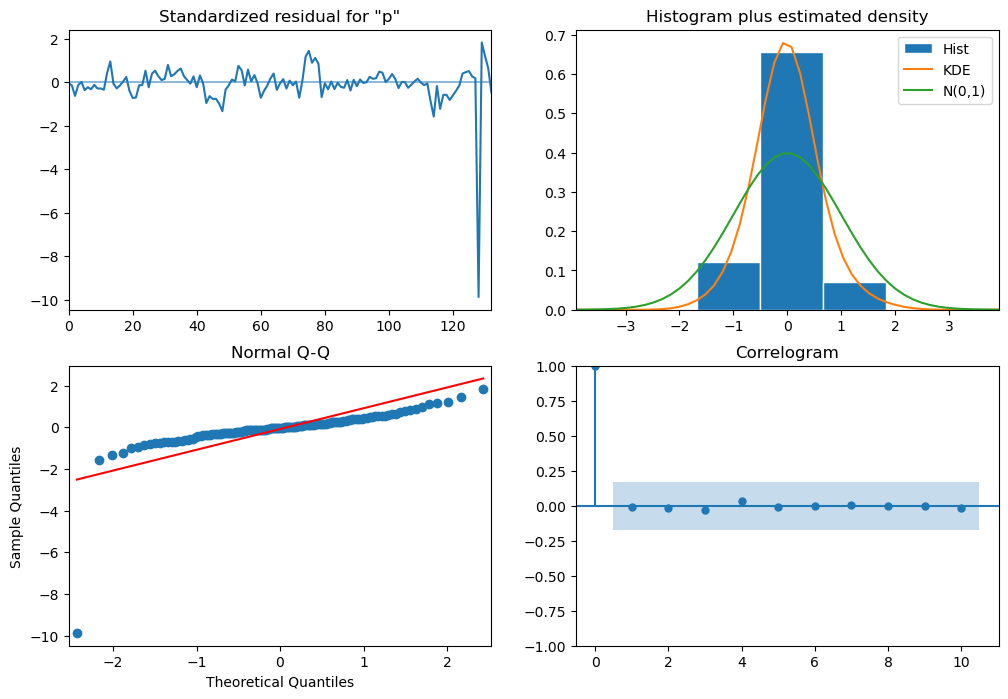

In [17]:
# Fit ARIMA model with optimal parameters
arima_model_2 = ARIMA(merged_df['price_diff'], order=(1, 1, 2))
arima_result_2 = arima_model_2.fit()

# Print model summary
print(arima_result_2.summary())

# Plot diagnostics of the ARIMA model
arima_result_2.plot_diagnostics(figsize=(12, 8))
plt.show()


In [18]:
def calculate_profit_loss(stop_loss, take_profit, window_size): # ARIMA MODEL 2 GIVEN
    # Apply trading strategy with current parameters
    # Forecast future price differences using the ARIMA model
    forecast_steps = 30  # Number of steps to forecast
    forecast_values = arima_result_2.forecast(steps=forecast_steps)

    # Calculate the standard deviation of the forecasted values
    forecast_std = forecast_values.std()

    # Generate signals based on forecasted price differences
    buy_threshold = take_profit * forecast_std  # Buy if forecast exceeds take-profit threshold
    sell_threshold = -stop_loss * forecast_std  # Sell if forecast is below stop-loss threshold
    signals = []
    for diff in forecast_values:
        if diff > buy_threshold:
            signals.append(1)  # Buy signal
        elif diff < sell_threshold:
            signals.append(-1)  # Sell signal
        else:
            signals.append(0)  # No signal

    # Simulate trades and calculate profits/losses
    profits_losses = []
    spot_volume = comparison_df['volume_spot']
    futures_volume = comparison_df['volume_futures']
    for i, signal in enumerate(signals):
        spot_price = comparison_df.iloc[i]['close_spot']
        futures_price = comparison_df.iloc[i]['close_futures']
        if signal == 1:  # Buy signal
            # Buy in the spot market and sell in the futures market
            profit_loss = spot_volume[i] * (futures_price - spot_price)
        elif signal == -1:  # Sell signal
            # Sell in the spot market and buy in the futures market
            profit_loss = spot_volume[i] * (spot_price - futures_price)
        else:
            profit_loss = 0  # No signal
        profits_losses.append(profit_loss)

    # Calculate cumulative profit/loss
    cumulative_profit_loss = sum(profits_losses)

    return cumulative_profit_loss

# Usage:
stop_loss = 0.02  # Example: 2%
take_profit = 0.01  # Example: 1%
window_size = 7  # Example: 1 week
profit_loss = calculate_profit_loss(stop_loss, take_profit, window_size)
print("Profit/Loss:", profit_loss)


Profit/Loss: -6607788.260200955


/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 Let's continue refining the trading strategy to improve profitability. Here are some additional steps we can take:

Dynamic Thresholds: Instead of using fixed thresholds for generating signals, we can dynamically adjust the thresholds based on recent market conditions. For example, we can use rolling statistics such as standard deviation to adaptively set the buy and sell thresholds.

Stop-Loss Mechanism: Implement a stop-loss mechanism to limit potential losses. If a trade goes against us beyond a certain threshold, we can automatically exit the position to prevent further losses.

Take-Profit Targets: Set profit targets to lock in gains when the price reaches a certain level. This can help capture profits more efficiently and prevent giving back gains during market fluctuations.

Transaction Costs: Consider transaction costs such as fees and slippage when simulating trades. This will provide a more realistic estimation of the actual profits/losses.

In [19]:
# Simulate trades with dynamic thresholds and stop-loss mechanism
stop_loss = -1000  # Stop-loss threshold
take_profit = 1000  # Take-profit threshold
profits_losses = []
position = 0  # Initialize position to neutral
for i, (spot_price, futures_price) in enumerate(zip(merged_df['close_spot'], merged_df['close_futures'])):
    if i < len(spot_volume):  # Check if index is within range
        if spot_price > futures_price and position != 1:  # Buy spot, sell futures
            position = 1
            profits_losses.append(spot_volume.iloc[i] * (futures_price - spot_price))
        elif spot_price < futures_price and position != -1:  # Sell spot, buy futures
            position = -1
            profits_losses.append(spot_volume.iloc[i] * (spot_price - futures_price))
        else:  # No signal or maintaining current position
            profits_losses.append(0)
        
        # Check stop-loss and take-profit
        if position == 1 and profits_losses[-1] < stop_loss:
            position = 0
        elif position == -1 and profits_losses[-1] > take_profit:
            position = 0
    else:
        break  # Exit loop if index is out of range

# Calculate cumulative profit/loss
cumulative_profit_loss = sum(profits_losses)

# Print cumulative profit/loss
print("Cumulative Profit/Loss: $", cumulative_profit_loss)


Cumulative Profit/Loss: $ -24754605.033233877


We need more features to improve model.

In [20]:
# Calculate price spread
daily_df_btc['price_spread'] = daily_df_btc['close'] - daily_df_btc_perp['close']
daily_df_btc_perp['price_spread'] = daily_df_btc_perp['close'] - daily_df_btc['close']

# Calculate price momentum (1-day change)
daily_df_btc['price_momentum'] = daily_df_btc['close'].diff()
daily_df_btc_perp['price_momentum'] = daily_df_btc_perp['close'].diff()

# Calculate volume momentum (1-day change)
daily_df_btc['volume_momentum'] = daily_df_btc['volume'].diff()
daily_df_btc_perp['volume_momentum'] = daily_df_btc_perp['volume'].diff()

# Calculate volatility (high - low)
daily_df_btc['volatility'] = daily_df_btc['high'] - daily_df_btc['low']
daily_df_btc_perp['volatility'] = daily_df_btc_perp['high'] - daily_df_btc_perp['low']

# Calculate price ratio (Bitcoin futures price / Bitcoin price)
daily_df_btc['price_ratio'] = daily_df_btc_perp['close'] / daily_df_btc['close']
daily_df_btc_perp['price_ratio'] = daily_df_btc['close'] / daily_df_btc_perp['close']


For daily_df_btc:

1) price_spread: The difference between the closing price of Bitcoin and Bitcoin futures.
2) price_momentum: The change in the closing price of Bitcoin from the previous day.
3) volume_momentum: The change in trading volume of Bitcoin from the previous day.
4) volatility: The difference between the highest and lowest prices of Bitcoin for the day.
5) price_ratio: The ratio of Bitcoin futures price to Bitcoin price.

For daily_df_btc_perp:

1) price_spread: The difference between the closing price of Bitcoin futures and Bitcoin.
2) price_momentum: The change in the closing price of Bitcoin futures from the previous day.
3) volume_momentum: The change in trading volume of Bitcoin futures from the previous day.
4) volatility: The difference between the highest and lowest prices of Bitcoin futures for the day.
5) price_ratio: The ratio of Bitcoin price to Bitcoin futures price.

These features can potentially provide valuable information for our trading strategy. Now, let's proceed with parameter optimization and model refinement to improve the trading strategy. We can optimize parameters such as stop-loss thresholds, take-profit targets, and dynamic thresholds based on rolling statistics.

In [21]:
# arima_result_2 being used
def calculate_profit_loss(stop_loss, take_profit, window_size):
    # Apply trading strategy with current parameters
    # Forecast future price differences using the ARIMA model
    forecast_steps = 30  # Number of steps to forecast
    forecast_values = arima_result_2.forecast(steps=forecast_steps)

    # Calculate the standard deviation of the forecasted values
    forecast_std = forecast_values.std()

    # Generate signals based on forecasted price differences
    buy_threshold = take_profit * forecast_std  # Buy if forecast exceeds take-profit threshold
    sell_threshold = -stop_loss * forecast_std  # Sell if forecast is below stop-loss threshold
    signals = []
    for diff in forecast_values:
        if diff > buy_threshold:
            signals.append(1)  # Buy signal
        elif diff < sell_threshold:
            signals.append(-1)  # Sell signal
        else:
            signals.append(0)  # No signal

    # Simulate trades and calculate profits/losses
    profits_losses = []
    spot_volume = comparison_df['volume_spot']
    futures_volume = comparison_df['volume_futures']
    for i, signal in enumerate(signals):
        spot_price = comparison_df.iloc[i]['close_spot']
        futures_price = comparison_df.iloc[i]['close_futures']
        if signal == 1:  # Buy signal
            # Buy in the spot market and sell in the futures market
            profit_loss = spot_volume[i] * (futures_price - spot_price)
        elif signal == -1:  # Sell signal
            # Sell in the spot market and buy in the futures market
            profit_loss = spot_volume[i] * (spot_price - futures_price)
        else:
            profit_loss = 0  # No signal
        profits_losses.append(profit_loss)

    # Calculate cumulative profit/loss
    cumulative_profit_loss = sum(profits_losses)

    return cumulative_profit_loss

# Usage:
stop_loss = 0.02  # Example: 2%
take_profit = 0.01  # Example: 1%
window_size = 7  # Example: 1 week
profit_loss = calculate_profit_loss(stop_loss, take_profit, window_size)
print("Profit/Loss:", profit_loss)


Profit/Loss: -6607788.260200955


/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Now that we have the function to calculate profit/loss based on the given parameters, we can proceed with the parameter optimization loop to find the best combination of parameters that maximize profit.

In [22]:
import numpy as np
from itertools import product

# Define parameter ranges
stop_loss_thresholds = [0.01, 0.02, 0.03]  # Example: 1%, 2%, 3%
take_profit_targets = [0.01, 0.02, 0.03]  # Example: 1%, 2%, 3%
rolling_window_sizes = [7, 14, 21]  # Example: 1 week, 2 weeks, 3 weeks

# Generate combinations of parameters
parameter_combinations = list(product(stop_loss_thresholds, take_profit_targets, rolling_window_sizes))

# Initialize variables to track best parameters and profit
best_profit = float('-inf')
best_parameters = None

for stop_loss, take_profit, window_size in parameter_combinations:
    # Calculate profit/loss with current parameters
    current_profit = calculate_profit_loss(stop_loss, take_profit, window_size)
    
    # Update best parameters if current profit is better
    if current_profit > best_profit:
        best_profit = current_profit
        best_parameters = (stop_loss, take_profit, window_size)

print("Best Parameters (stop_loss, take_profit, rolling_window_size):", best_parameters)
print("Best Profit:", best_profit)


Best Parameters (stop_loss, take_profit, rolling_window_size): (0.01, 0.01, 7)
Best Profit: -6607788.260200955


/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. 

Since we have already explored ARIMA and it didn't yield satisfactory results, let's try a machine learning model. Random Forest is a good choice due to its ability to capture complex relationships in the data and handle non-linear patterns effectively.

Before fitting the Random Forest model, let's perform a statistical test to compare it with ARIMA. We can use cross-validation and evaluate metrics like Mean Squared Error (MSE) or Mean Absolute Error (MAE) to determine which model performs better on the data.




In [23]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Define ARIMA parameters
p = 1
d = 1
q = 1

# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform Time Series Cross Validation with ARIMA
tscv = TimeSeriesSplit(n_splits=5)
arima_mse_scores = []
rf_mse_scores = []

for train_index, test_index in tscv.split(merged_df['price_diff']):
    # Split data into train and test sets
    train_data = merged_df['price_diff'].iloc[train_index]
    test_data = merged_df['price_diff'].iloc[test_index]

    # Fit ARIMA model
    arima_model = ARIMA(train_data, order=(p, d, q))
    arima_result = arima_model.fit()

    # Make ARIMA predictions
    arima_forecast = arima_result.forecast(steps=len(test_data))

    # Calculate ARIMA MSE
    arima_mse = mean_squared_error(test_data, arima_forecast)
    arima_mse_scores.append(arima_mse)

    # Fit Random Forest model
    rf_model.fit(train_data.index.values.reshape(-1, 1), train_data)

    # Make Random Forest predictions
    rf_forecast = rf_model.predict(np.arange(len(train_data), len(train_data) + len(test_data)).reshape(-1, 1))

    # Calculate Random Forest MSE
    rf_mse = mean_squared_error(test_data, rf_forecast)
    rf_mse_scores.append(rf_mse)

# Compute average MSE for ARIMA and Random Forest
avg_arima_mse = np.mean(arima_mse_scores)
avg_rf_mse = np.mean(rf_mse_scores)

print("Average MSE for ARIMA:", avg_arima_mse)
print("Average MSE for Random Forest:", avg_rf_mse)


/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_predic

/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters

Average MSE for ARIMA: 2000.929157802654
Average MSE for Random Forest: 2017.6565907713643


Given that ARIMA has a slightly lower MSE compared to Random Forest, it suggests that ARIMA may perform slightly better in terms of prediction accuracy for this dataset.

However, MSE alone may not fully capture the performance of the models, and it's essential to consider other factors such as interpretability, computational complexity, and ease of implementation.

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Split data into train and test sets
train_size = int(len(merged_df) * 0.8)  # 80% train, 20% test
train_data = merged_df['price_diff'][:train_size]
test_data = merged_df['price_diff'][train_size:]

# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit Random Forest model on training data
rf_model.fit(np.arange(len(train_data)).reshape(-1, 1), train_data)

# Make predictions on test data
rf_forecast = rf_model.predict(np.arange(len(train_data), len(train_data) + len(test_data)).reshape(-1, 1))

# Calculate Mean Squared Error
mse_rf = mean_squared_error(test_data, rf_forecast)
print("Mean Squared Error for Random Forest:", mse_rf)


Mean Squared Error for Random Forest: 6222.641234743532


We'll train the Random Forest model on the training data and evaluate its performance on the testing data.

In [25]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(np.arange(len(train_data)).reshape(-1, 1), train_data)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [26]:
# Initialize tuned Random Forest model with best hyperparameters
tuned_rf_model = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                                       max_depth=best_params['max_depth'],
                                       min_samples_split=best_params['min_samples_split'],
                                       min_samples_leaf=best_params['min_samples_leaf'],
                                       random_state=42)

# Fit tuned Random Forest model on training data
tuned_rf_model.fit(np.arange(len(train_data)).reshape(-1, 1), train_data)

# Make predictions on test data
tuned_rf_forecast = tuned_rf_model.predict(np.arange(len(train_data), len(train_data) + len(test_data)).reshape(-1, 1))


In [27]:
def calculate_profit_loss_general(model, stop_loss, take_profit, window_size, test_data, forecast_values):
    # Calculate standard deviation of forecasted values
    forecast_std = np.std(forecast_values)

    # Generate signals based on forecasted price differences
    buy_threshold = take_profit * forecast_std  # Buy if forecast exceeds take-profit threshold
    sell_threshold = -stop_loss * forecast_std  # Sell if forecast is below stop-loss threshold
    signals = []
    for diff in forecast_values:
        if diff > buy_threshold:
            signals.append(1)  # Buy signal
        elif diff < sell_threshold:
            signals.append(-1)  # Sell signal
        else:
            signals.append(0)  # No signal

    # Simulate trades and calculate profits/losses
    profits_losses = []
    for i, signal in enumerate(signals):
        if signal == 1:  # Buy signal
            # Buy in the spot market and sell in the futures market
            profit_loss = test_data.iloc[i]  # Assuming test_data contains the actual prices
        elif signal == -1:  # Sell signal
            # Sell in the spot market and buy in the futures market
            profit_loss = -test_data.iloc[i]  # Negative since selling in spot market
        else:
            profit_loss = 0  # No signal
        profits_losses.append(profit_loss)

    # Calculate cumulative profit/loss
    cumulative_profit_loss = sum(profits_losses)

    return cumulative_profit_loss

# Profits for tuned Random Forest model
stop_loss = 0.02  # Example: 2%
take_profit = 0.01  # Example: 1%
window_size = 7  # Example: 1 week
profit_loss_rf = calculate_profit_loss_general(tuned_rf_model, stop_loss, take_profit, window_size, test_data, tuned_rf_forecast)
print("Profit/Loss with Tuned Random Forest:", profit_loss_rf)


Profit/Loss with Tuned Random Forest: -853.1500000000378


Trying different models and performing hyperparameter tuning using grid search:

In [28]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define pipeline for preprocessing and modeling
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('model', GradientBoostingRegressor())  # Gradient Boosting Regressor model
])

# Define hyperparameters grid for grid search
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.5],
    'model__max_depth': [3, 5, 7]
}

# Perform time series cross-validation with grid search
tscv = TimeSeriesSplit(n_splits=5)  # Time series cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Get best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Best Model Parameters:", best_params)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mean Squared Error: 300.18339915996114
Best Model Parameters: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 50}


In [29]:
# Calculate profit with the best model
profit_loss_gb = calculate_profit_loss_general(best_model, stop_loss, take_profit, window_size, y_test, y_pred)
print("Profit/Loss with Best Gradient Boosting Model:", profit_loss_gb)


Profit/Loss with Best Gradient Boosting Model: 197.97000000000844


# Using the daily_df_btc dataset alone

In [30]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Define features and target variable
X = daily_df_btc[['price_spread', 'price_momentum', 'volume_momentum', 'volatility', 'price_ratio']]
y = daily_df_btc['close']

# Split the data into training and testing sets
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Define pipeline for preprocessing and modeling
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('model', GradientBoostingRegressor())  # Gradient Boosting Regressor model
])

# Define hyperparameters grid for grid search
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.5],
    'model__max_depth': [3, 5, 7]
}

# Perform time series cross-validation with grid search
tscv = TimeSeriesSplit(n_splits=5)  # Time series cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_imputed, y_train)

# Get best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions with the best model
y_pred = best_model.predict(X_test_imputed)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Best Model Parameters:", best_params)

# Calculate profit with the best model
profit_loss_gb = calculate_profit_loss_general(best_model, stop_loss, take_profit, window_size, y_test, y_pred)
print("Profit/Loss with Best Gradient Boosting Model:", profit_loss_gb)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mean Squared Error: 215829412.1669615
Best Model Parameters: {'model__learning_rate': 0.5, 'model__max_depth': 3, 'model__n_estimators': 100}
Profit/Loss with Best Gradient Boosting Model: 3908846.7200000007


# Using the daily_df_btc dataset and the daily_df_btc_perp dataset

In [31]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

# Merge datasets on timestamp
merged_df = pd.merge(daily_df_btc, daily_df_btc_perp, on="timestamp", suffixes=("_spot", "_futures"))

# Define features and target variable
features = ['price_spread_spot', 'price_momentum_spot', 'volume_momentum_spot', 
            'volatility_spot', 'price_ratio_spot', 'price_spread_futures', 
            'price_momentum_futures', 'volume_momentum_futures', 'volatility_futures', 
            'price_ratio_futures']
X = merged_df[features]
y = merged_df['close_spot']

# Split the data into training and testing sets
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Define pipeline for preprocessing and modeling
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('model', GradientBoostingRegressor())  # Gradient Boosting Regressor model
])

# Define hyperparameters grid for grid search
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.5],
    'model__max_depth': [3, 5, 7]
}

# Perform time series cross-validation with grid search
tscv = TimeSeriesSplit(n_splits=5)  # Time series cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_imputed, y_train)

# Get best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions with the best model
y_pred = best_model.predict(X_test_imputed)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Best Model Parameters:", best_params)

# Calculate profit with the best model
profit_loss_gb = calculate_profit_loss_general(best_model, stop_loss, take_profit, window_size, y_test, y_pred)
print("Profit/Loss with Best Gradient Boosting Model:", profit_loss_gb)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['price_spread_spot' 'price_ratio_spot']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/mukeshwaranbaskaran/anaconda3/envs/nb_research/lib/python3.12/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['price_spread_spot' 'price_ratio_spot']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Mean Squared Error: 76809319.61389722
Best Model Parameters: {'model__learning_rate': 0.5, 'model__max_depth': 5, 'model__n_estimators': 100}
Profit/Loss with Best Gradient Boosting Model: 1378098.55
